In [6]:
import random
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp

In [7]:
from numba import njit

In [8]:
from rewards import Rewards

In [9]:
Rs = Rewards

In [10]:
len(Rs)

805

In [11]:
# from Sam Zorowitz code — add citation here!

@njit
def inv_logit(arr):
    """Fast inverse logistic function."""
    return 1. / (1. + np.exp(-arr))

@njit
def softmax(arr):
    """Scale-robust softmax function"""
    arr = np.exp(arr - np.max(arr))
    return arr / arr.sum()

@njit
def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal.'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

In [12]:
# constants
SA = 0
SB = 1
SC = 2

In [19]:
class UnluckySymbol(object):
    def __init__(self, trials, Rs, a, b, eta):
        
        self.n_trials = trials
        
        self.R = Rs
        self.state = SA
        
        # define parameters
        self.alpha = a
        self.beta = b
        self.eta = eta
        
        # define values
        self.MB = np.zeros((2, 2))
        
        self.rewards = np.zeros(trials)
        self.choices = np.zeros((trials, 2))
        self.choice1_outcomes = np.zeros(trials)
        self.switch = np.zeros(trials)
        self.common = np.zeros(trials)
        
        self.transitions = np.array([
            [0.7, 0.3],
            [0.3, 0.7]
        ])
        
        self.transition_count = np.zeros((2,2,2))
        self.final_state = np.zeros(trials) # 1 = SB, 2 = SC
        
    def possible_switch(self, choice):
        if random.random() < 0.7:
            return choice
        return 1 - choice
    
    def update_stay_prob(self, action, t):
        self.transition_count[
            int(not self.rewards[t-1]),
            int(not self.common[t-1]),
            int(not (self.choice1_outcomes[t-1] == action))
        ] += 1
        
    def compute_stay_prob(self, transition_count):
        # stay_prob[r,c,a] = P[r,c,a] / (P[r,c,a] + P[r,c,~a]) 
        action_count = transition_count.sum(axis=-1)
        return transition_count / action_count[:, :, np.newaxis]

    def train(self, R):
        
        for t in range(self.n_trials):
            
            self.state = SA
            
            ## Action selection.
            d1 = 0.7*max(self.MB[1]) + 0.3*max(self.MB[0]) - self.eta*(0.3*max(self.MB[1]) + 0.7*max(self.MB[0]))
            
            # choice probabilities and making choice
            theta1 = inv_logit( self.beta * d1 )
            choice1 = np.random.binomial(1, theta1)
            self.choices[t,0] = choice1
            
            # observe outcome and possible switch
            outcome1 = self.possible_switch(choice1)
            self.choice1_outcomes[t] = outcome1
            
            # update values for stay_probs
            if t > 0:    
                self.update_stay_prob(outcome1, t)
            
            reward_probs = None
            # update state
            if self.choice1_outcomes[t] == 0: # went LEFT
                self.state = SB
                self.final_state[t] = 1
                reward_probs = self.R[t][0:2]
            else: # went RIGHT
                self.state = SC
                self.final_state[t] = 2
                reward_probs = self.R[t][2:4]
            
            # count possible switch
            if (self.choices[t,0] == 1 & self.state == SB) | (self.choices[t,0] == 0 & self.state == SC):
                self.switch[t] = 1
            else:
                self.common[t] = 1
            
            # possible value reduction
            value_reduc = eta if (choice1 == 0) else 1
            
            # make second-level choice
            d2 = value_reduc*self.beta*(self.MB[outcome1,1] - self.MB[outcome1,0])

            theta2 = inv_logit( d2 )
            choice2 = np.random.binomial(1, theta2)
            self.choices[t,1] = choice2
            
            # get what the reward is
            final_prob = reward_probs[choice2]
            reward = np.random.binomial(1, final_prob)
            self.rewards[t] = reward
            
            # update values
            self.MB[outcome1, choice2] = (1 - self.alpha)*self.MB[outcome1, choice2] + self.alpha*self.rewards[t]

            
    def plot(self, transition_count=None, title="Unlucky Symbol: Two-Step Task", y_lim=0.5):
        _,ax = plt.subplots(1,1,figsize=[10,6])

        ax.set_ylim([y_lim, 1.0])
        ax.set_ylabel('Stay Probability')
        ax.set_title(title)

        if transition_count is None:
            transition_count = self.transition_count
        
        stay_probs = self.compute_stay_prob(transition_count)
        
        common = [stay_probs[0,0,0], stay_probs[1,0,0]]
        uncommon = [stay_probs[0,1,0], stay_probs[1,1,0]]
        
        ax.set_xticks([1.5,3.5])
        ax.set_xticklabels(['Rewarded', 'Unrewarded'])
        ax.set_ylim(0,1)
        
        c = plt.bar([1,3], common, color='b', width=0.5)
        uc = plt.bar([2,4], uncommon, color='r', width=0.5)
        ax.legend( (c[0], uc[0]), ('Common', 'Uncommon') )

In [20]:
n_agents = 1
trials = 400
alpha = 0.5
beta = 5.00
eta  = 0.5 

In [21]:
agents = UnluckySymbol(trials, Rs, alpha, beta, eta)

In [22]:
np.random.seed(47404)

In [23]:
Y = agents.train(Rs)

In [24]:
agents.final_state

array([2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 2., 1., 2., 2.,
       1., 2., 2., 2., 1., 1., 2., 1., 2., 1., 2., 2., 1., 1., 1., 1., 1.,
       2., 2., 1., 1., 2., 2., 2., 1., 2., 2., 1., 2., 1., 2., 2., 1., 2.,
       2., 1., 2., 2., 1., 1., 2., 2., 1., 2., 2., 2., 2., 1., 1., 2., 2.,
       1., 2., 1., 2., 1., 2., 2., 2., 2., 2., 1., 1., 1., 2., 2., 2., 1.,
       2., 2., 2., 1., 1., 2., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 1., 2., 1., 2., 2., 2., 1., 1., 1., 2., 1., 2., 1., 2.,
       2., 2., 1., 2., 2., 1., 1., 1., 2., 2., 1., 1., 2., 1., 1., 2., 2.,
       2., 1., 1., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 1., 2.,
       2., 2., 2., 1., 1., 2., 2., 2., 2., 1., 2., 1., 2., 2., 1., 2., 2.,
       2., 2., 1., 2., 2., 2., 1., 1., 2., 2., 2., 1., 1., 1., 2., 1., 2.,
       2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 1., 2., 2., 2., 2., 1., 2.,
       2., 1., 1., 1., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 1., 2.,
       1., 2., 1., 2., 1.

In [25]:
rew = agents.rewards

In [26]:
rares = agents.switch

In [27]:
commons = agents.common

In [28]:
# looking for HIGHER STAY PROBABILITY:
    # if common and was rewarded ()
    # or uncommon and wasn't rewarded (switch, and no reward)

com_rew = []
com_unrew = []

rare_unrew = []
rare_rew = []
    
for i in range(trials):
    if (commons[i] == 1):
        com_rew.append(i) if (rew[i] == 1) else com_unrew.append(i)

    if (rares[i] == 1):
        rare_unrew.append(i) if (rew[i] == 0) else rare_rew.append(i)

In [29]:
len(com_rew)

135

In [30]:
len(rare_unrew)

54

In [31]:
len(rare_rew)

35

In [32]:
len(com_unrew)

176

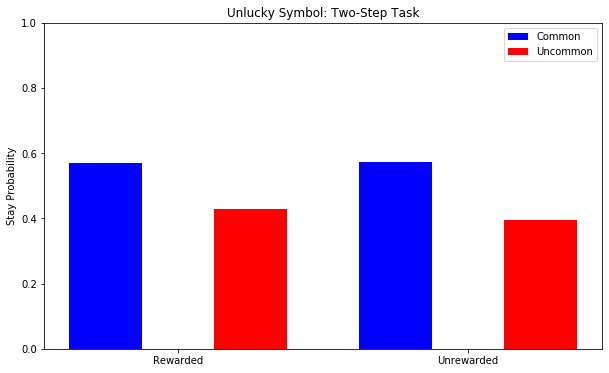

In [33]:
agents.plot()

### [EDIT] Sam Notes

In this cell, I'll review the equations for the model-based agent, originally defined in the [supplement of Daw et al (2011)](https://ars.els-cdn.com/content/image/1-s2.0-S0896627311001255-mmc1.pdf). 

#### Stage 2 Choice

In stage 2, the agent makes a choice between two actions, $Q(s_i, a_1)$ and $Q(s_i,a_2$), conditioned on the current state. As discussed in [Daw (2011)](https://pdfs.semanticscholar.org/43c3/d7653710bbb477df108fc2ed2729429d053c.pdf), in the case of two options, the softmax reduces to the [inverse logit function](https://en.wikipedia.org/wiki/Logistic_function). Thus, the probability of the agent taking action 1 is:

$$ p( a_1 \mid s_i, \beta_2 ) = \text{logit}^{-1} \left( \beta_2 \cdot [Q(s_i, a_1) - Q(s_i, a_2)] \right) = \frac{1}{1 + \exp \left(-\beta_2 \cdot [Q(s_i, a_1) - Q(s_i, a_2)] \right)} $$

Note that the action probability is a function of a choice sensitivity (inverse temperature) parameter, $\beta_2$. The subscript indicates that this parameter is specific to the second stage. As you will see below, we introduce a separate choice sensitivity parameter for first stage choice (even though we typically set these to the same value).

#### Stage 2 Learning

In stage 2, following a choice, the agent updates its expectations of the value of the chosen action, $Q(s_{i,t+1} a_{i,t+1})$, based on the observed reward, $r_t$. This update folows temporal difference learning:

$$ Q(s_{i,t+1} a_{i,t+1}) = Q(s_{i,t}, a_{i,t}) + \eta_2 \delta_t $$

where $\delta_t$ is the reward prediction error on trial $t$, defined as:

$$ \delta_t = r_t - Q(s_{i,t}, a_{i,t}) $$

Two notes here:

1. We introduce the trial $t$ notation here to denote that learning updates affect behavior on the next trial.
2. We introduce the stage notation here for learning rate to indicate that this parameter is specific to stage 2.

#### Stage 1 Choice

Now here's the complicated part. We make two assumptions about the model-based agent:

1. The agent recomputes the value of each stage 1 action based on its current estimates of the value of the second stage choices at the start of each trial.
2. The agent performs this computation assuming an *off-policy* strategy (i.e. assuming it will take the best action at any successor state).

Following Bellman's equation, the model-based agent computes the value of each first stage action taking into consideration the state-transition probaiblities, $T(s' \mid s_1, a_i)$, and value of the best action in each successor state. 

For notational convenience, let's define the transition probabilities as:
- $ p( s_2 \mid s_1, a_1) = 0.7 $, i.e. 70% probability of ending up in State 2 given Action 1 in State 1
- $ p( s_3 \mid s_1, a_1) = 0.3 $, i.e. 30% probability of ending up in State 3 given Action 1 in State 1
- $ p( s_2 \mid s_1, a_2) = 0.3 $, i.e. 30% probability of ending up in State 2 given Action 2 in State 1
- $ p( s_3 \mid s_1, a_2) = 0.7 $, i.e. 70% probability of ending up in State 3 given Action 2 in State 1

Then we can define the value of action 1 in stage 1 as:

$$ Q(s_1, a_1) = p( s_2 \mid s_1, a_1) \cdot \max Q(s_2, a) + p( s_3 \mid s_1, a_1) \cdot \max Q(s_3, a) $$
$$ = 0.7 \cdot \max Q(s_2, a) + 0.3 \cdot \max Q(s_3, a) $$

and the value of action 2 in stage 1 as:

$$ Q(s_1, a_2) = p( s_2 \mid s_1, a_2) \cdot \max Q(s_2, a) + p( s_3 \mid s_1, a_2) \cdot \max Q(s_3, a) $$
$$ = 0.3 \cdot \max Q(s_2, a) + 0.7 \cdot \max Q(s_3, a) $$

And finally, we use the inverse logit function to assign probabilities of taking either action 1 vs. action 2 in stage 1:

$$ p( a_1 \mid s_1, \beta_1 ) = \text{logit}^{-1} \left( \beta_1 \cdot [Q(s_1, a_1) - Q(s_1, a_2)] \right) = \frac{1}{1 + \exp \left(-\beta_1 \cdot [Q(s_1, a_1) - Q(s_1, a_2)] \right)} $$


Note that the action probability is a function of a separate choice sensitivity (inverse temperature) parameter, $\beta_1$. The subscript indicates that this parameter is specific to the first stage. As noted above, we typically set the value of choice sensitivity for both stages, $\beta_1$ and $\beta_2$, to be the same but they don't have to be!

In [94]:
# Model-Based Strategy

class model_based(object):
    def __init__(self, trials, Rs, a, b1, b2=None):
        
        self.n_trials = trials
 
        self.R = Rs
        self.state = SA
        
        # define parameters
        self.alpha = a
        self.beta1 = b1
        
        if b2 == None:
            self.beta2 = b1
        else:
            self.beta2 = b2
        
        # define values
        self.MB = np.zeros((2, 2))
        
        self.rewards = np.zeros(trials)
        self.choices = np.zeros((trials, 2))
        self.choice1_outcomes = np.zeros(trials)
        self.switch = np.zeros(trials)
        self.common = np.zeros(trials)
        
        self.transitions = np.array([
            [0.7, 0.3],
            [0.3, 0.7]
        ])
        
        self.transition_count = np.zeros((2,2,2))
        self.final_state = np.zeros(trials) # 1 = SB, 2 = SC
        
    def possible_switch(self, choice):
        if random.random() < 0.7:
            return choice
        return 1 - choice
    
    def update_stay_prob(self, action, t):
        self.transition_count[
            int(not self.rewards[t-1]),
            int(not self.common[t-1]),
            int(not (self.choice1_outcomes[t-1] == action))
        ] += 1
        
    def compute_stay_prob(self, transition_count):
        # stay_prob[r,c,a] = P[r,c,a] / (P[r,c,a] + P[r,c,~a]) 
        action_count = transition_count.sum(axis=-1)
        return transition_count / action_count[:, :, np.newaxis]

    def train(self, R):
        
        for t in range(self.n_trials):
            
            self.state = SA
            
            ## Action selection.
            v1 = 0.7*max(self.MB[0]) + 0.3*max(self.MB[1])
            v2 = 0.3*max(self.MB[0]) + 0.7*max(self.MB[1])

            # choice probabilities and making choice
            theta1 = inv_logit( self.beta1 * (v1 - v2) )
            choice1 = np.random.binomial(1, theta1)
            self.choices[t,0] = choice1
            
            # observe outcome and possible switch
            outcome1 = self.possible_switch(choice1)
            self.choice1_outcomes[t] = outcome1
            
            # update values for stay_probs
            if t > 0:    
                self.update_stay_prob(outcome1, t)
            
            reward_probs = None
            # update state
            if self.choice1_outcomes[t] == 0: # went LEFT
                self.state = SB
                self.final_state[t] = 1
                reward_probs = self.R[t][0:2]
            else: # went RIGHT
                self.state = SC
                self.final_state[t] = 2
                reward_probs = self.R[t][2:4]
            
            # count possible switch
            if (self.choices[t,0] == 1 & self.state == SB) | (self.choices[t,0] == 0 & self.state == SC):
                self.switch[t] = 1
            else:
                self.common[t] = 1
            
            # make second-level choice
            d2 = self.MB[outcome1,0] - self.MB[outcome1,1]

            theta2 = inv_logit( self.beta2 * d2 )
            choice2 = np.random.binomial(1, theta2)
            self.choices[t,1] = choice2
            
            # get what the reward is
            final_prob = reward_probs[choice2]
            reward = np.random.binomial(1, final_prob)
            self.rewards[t] = reward
            
            # update values
            # update level 2 MB value
            self.MB[outcome1, choice2] += self.alpha*(self.rewards[t] - self.MB[outcome1, choice2])
            
    def plot(self, transition_count=None, title="Model-Based Two-Step Task", y_lim=0.5):
        _,ax = plt.subplots(1,1,figsize=[10,6])

        ax.set_ylim([y_lim, 1.0])
        ax.set_ylabel('Stay Probability')
        ax.set_title(title)

        if transition_count is None:
            transition_count = self.transition_count
        
        stay_probs = self.compute_stay_prob(transition_count)
        
        common = [stay_probs[0,0,0], stay_probs[1,0,0]]
        uncommon = [stay_probs[0,1,0], stay_probs[1,1,0]]
        
        ax.set_xticks([1.5,3.5])
        ax.set_xticklabels(['Rewarded', 'Unrewarded'])
        ax.set_ylim(0,1)
        
        c = plt.bar([1,3], common, color='b', width=0.5)
        uc = plt.bar([2,4], uncommon, color='r', width=0.5)
        ax.legend( (c[0], uc[0]), ('Common', 'Uncommon') )


In [95]:
n_agents = 1
trials = 400
alpha = 0.5
beta = 10.00

In [96]:
np.random.seed(11408)
agents_MB = model_based(trials, Rs, alpha, beta)

In [97]:
MBtrained = agents_MB.train(Rs)

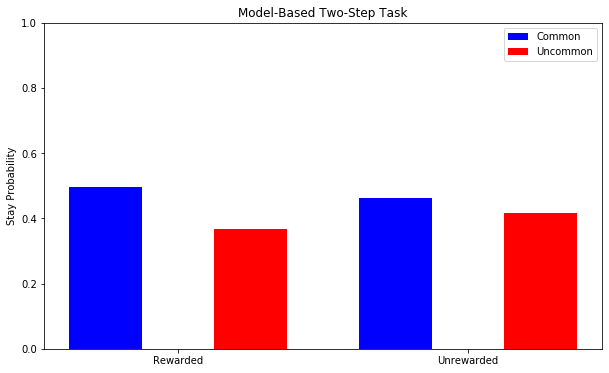

In [98]:
agents_MB.plot()

In [80]:
class StayProbabilitiesCalculator:
    """Helper class for the stay probabilities."""
    def __init__(self):
        self.prev_reward = None
        self.prev_transition = None
        self.prev_choice = None
        self.stay = [(0, 0) for _ in range(4)]
    def add_trial_info(self, choice1, fstate, _, reward):
        if self.prev_choice is not None:
            indx = 2*self.prev_reward + self.prev_transition
            num, den = self.stay[indx]
            self.stay[indx] = (num + int(self.prev_choice == choice1), den + 1)
        self.prev_reward = reward
        self.prev_transition = int(choice1 == fstate)
        self.prev_choice = choice1
    def get_stay_prob(self, reward, transition):
        num, den = self.stay[2*reward + transition]
        return num/den

In [82]:
spc = StayProbabilitiesCalculator()

In [88]:
choice1 = agents_MB.choices[:,0]
fstate = agents_MB.choice1_outcomes
choice2 = agents_MB.choices[:,1]
reward= agents_MB.rewards

In [420]:
# THIS IS WRONG!! —— something wrong here with the way that you are coding the task . . . 

In [410]:
# would this be better if we used two betas, one for each stage, like Daw and Toyama did?
# is this the right way to calculate Stay Probabilities? This seems low when you look at the graph . . . 